# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Data

## Image path

In [2]:
train_dir = "C:\\Users\\Mahesh\\tomatoleaf\\train"
test_dir = "C:\\Users\\Mahesh\\tomatoleaf\\val"

## Data Rescaling and augmentation

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
    input_shape=(112, 112, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load datasets (Shuffle and prefetch)

In [4]:
import tensorflow as tf

IMG_SIZE = (112, 112)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


## Visualize data

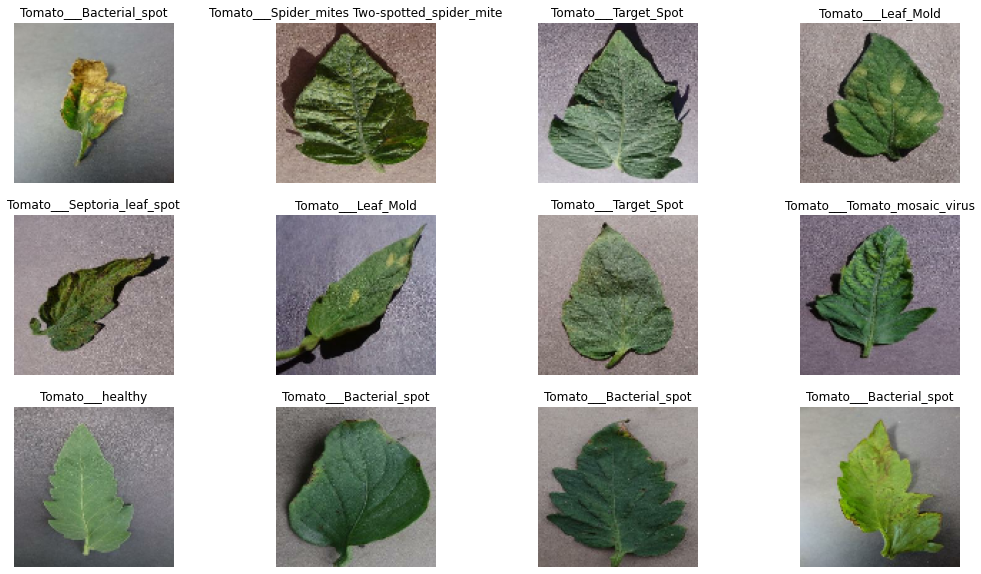

In [5]:
plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

## Augmented image view

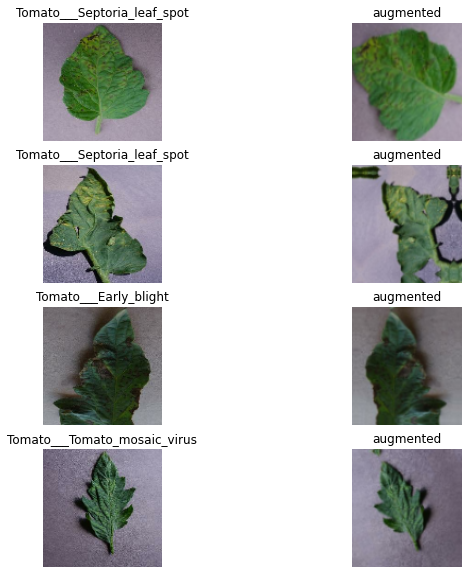

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

# Create Checkpoint

In [7]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [8]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

## Summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Compile model

In [10]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Fit the model

In [11]:
history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/100
313/313 [==============================] - 104s 330ms/step - loss: 2.1300 - accuracy: 0.1956 - val_loss: 1.9210 - val_accuracy: 0.2900
Epoch 2/100
313/313 [==============================] - 101s 324ms/step - loss: 1.7745 - accuracy: 0.3547 - val_loss: 1.7023 - val_accuracy: 0.3970
Epoch 3/100
313/313 [==============================] - 102s 325ms/step - loss: 1.5575 - accuracy: 0.4479 - val_loss: 1.4847 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 106s 339ms/step - loss: 1.3866 - accuracy: 0.5021 - val_loss: 1.2551 - val_accuracy: 0.5760
Epoch 5/100
313/313 [==============================] - 102s 327ms/step - loss: 1.2782 - accuracy: 0.5392 - val_loss: 1.3793 - val_accuracy: 0.5160
Epoch 6/100
313/313 [==============================] - 101s 324ms/step - loss: 1.1676 - accuracy: 0.5869 - val_loss: 1.0129 - val_accuracy: 0.6560
Epoch 7/100
313/313 [==============================] - 100s 319ms/step - loss: 1.0917 - accuracy: 0.6174 - val_loss: 0

# Create plot_loss_curve function

In [12]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## plot the model

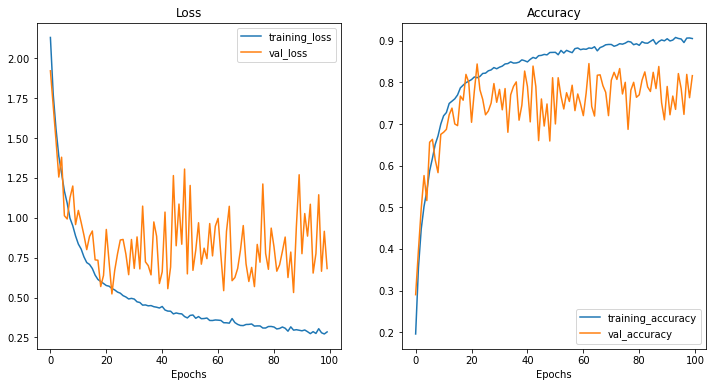

In [13]:
plot_loss_curves(history)

# Evaluate model

In [14]:
model.evaluate(test_data)

32/32 [==============================] - 2s 66ms/step - loss: 0.6817 - accuracy: 0.8160


[0.6817435622215271, 0.8159999847412109]

## Evaluate best model

### Load the best weight

In [15]:
model.load_weights(checkpoint_path)

### Evaluate

In [16]:
model.evaluate(train_data), model.evaluate(test_data)

32/32 [==============================] - 3s 80ms/step - loss: 0.5430 - accuracy: 0.8450


([0.4725373089313507, 0.8435999751091003],
 [0.5430018901824951, 0.8450000286102295])

In [17]:
import os
model_version=max([int(i) for i in os.listdir("C:\\Users\\Mahesh\\tomatoleaf\\saved_modell")+[0]])+1
model.save(f"C:\\Users\\Mahesh\\tomatoleaf\\saved_modell\\{model_version}")

INFO:tensorflow:Assets written to: C:\Users\Mahesh\tomatoleaf\saved_modell\1\assets


# Load pretrain model

## Download pre train model

In [18]:
import tensorflow as tf

## Laod model

In [19]:
load_model = tf.keras.models.load_model("C:\\Users\\Mahesh\\tomatoleaf\\saved_modell\\1")

## summary of load data

In [20]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

## Evaluate load model with valid data or test_data

In [21]:
load_model.evaluate(train_data),load_model.evaluate(test_data)

32/32 [==============================] - 3s 78ms/step - loss: 0.5430 - accuracy: 0.8450


([0.47253724932670593, 0.8435999751091003],
 [0.5430018305778503, 0.8450000286102295])

# Prediction && visualize

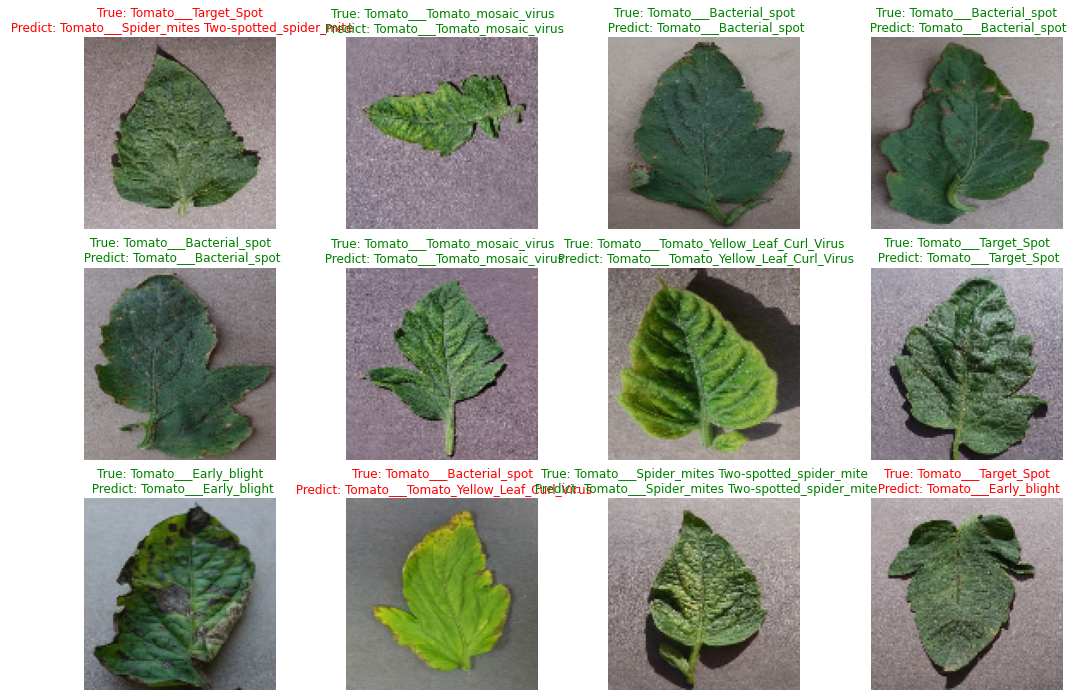

In [22]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

# Confusion matrix

In [23]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


## Predict y_pred and get y_true

In [24]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(load_model.predict(x), axis=-1)], axis=0)

## Plot confusion matrix

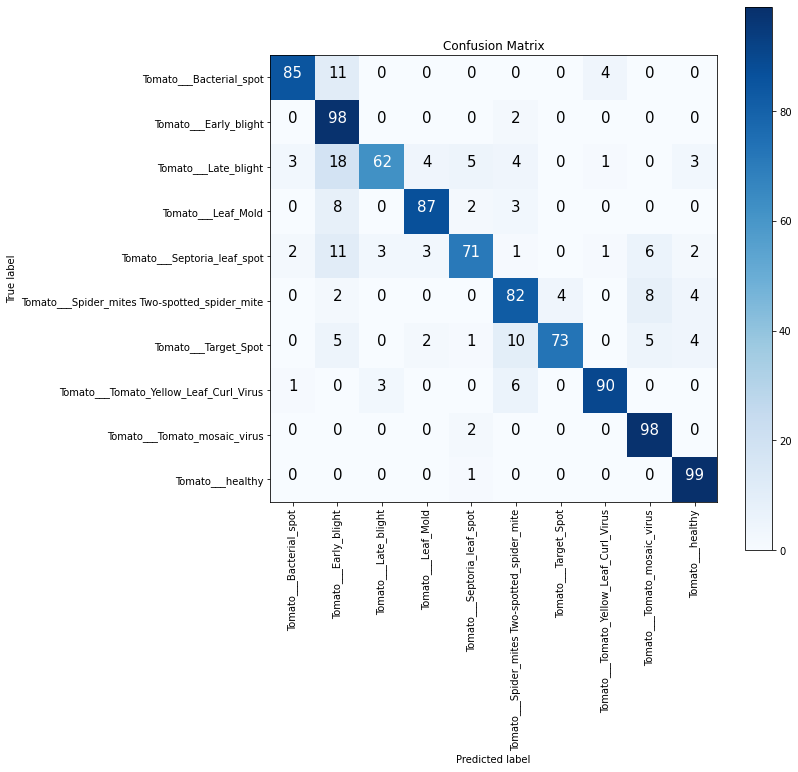

In [25]:
make_confusion_matrix(y_true, y_pred, class_names)